# 📘 Hadley Circulation Strength Analysis

This notebook analyzes the Hadley circulation strength using CESM2 output. It was tested and runs correctly on the author's machine.

---

## 🔧 Requirements

To run this notebook, please ensure you have the following:

### ✅ Python Packages
Install the necessary packages using:

```bash
pip install xarray numpy matplotlib netCDF4
```

### 📦 External Package
This notebook also uses an external package that you need to **manually download and install**. Please refer to the author's README or internal documentation for instructions.

If it’s hosted on GitHub, you might install it like this:

```bash
pip install git+https://github.com/username/external-climate-package.git
```

> Replace the URL above with the actual repo or installation method.

---

## 📂 Required Data

Ensure that the required `.nc` data files are in the same directory as this notebook (or adjust the paths accordingly).

---

## ▶️ How to Run

```bash
jupyter notebook Hadley_Circulation_Strength.ipynb
```

This will open the notebook in your browser. Run all cells from top to bottom.


Note: This script makes extensive use of xarray functionality to calculate the annual-mean Hadley Circulation Strength (HCS). Detailed definitions and methodology can be found in Hasan and Larson (2025) [Link]. Because this workflow relies heavily on xarray conventions, users are advised to carefully inspect the metadata of their own datasets before use. Differences in coordinate or dimension names (e.g., lat vs. latitude) and array orientation (e.g., latitude running from 90°S to 90°N versus 90°N to 90°S) can lead to incorrect or misleading results.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
from scipy import stats

In [6]:
## PytropD package (https://tropd.github.io/pytropd/index.html)
import pytropd.functions as pytf
import pytropd.metrics as pytm

In [7]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [8]:
start_year  = '1979-01'
end_year = '2014-12'

**Streamfucntion-based HCS**

In [9]:
## Zonal-mean V
ds_vx_FC_ensmean = xr.open_dataset('/gpfs_backup/slarson_data/mhasan6/Research/Dataset/CESM2_LE/FC_LE/postP/V/V_plev/zonmean/ensmean.V.197901-201412_plev.zonmean.nc')
vx = ds_vx_FC_ensmean.V.sel(time=slice(start_year,end_year)).squeeze() # Unit in m/s
ds_vx_FC_ensmean.close()

In [10]:
# Annual mean zonal-mean meridional wind
vx_ann = vx.groupby('time.year').mean('time')
del vx

In [11]:
## Streamfunction
vx_ann = vx_ann.transpose('year', 'lat', 'lev')
psi_ann = np.nan * vx_ann 
for i in range(len(vx_ann.year)):
    psi_ann[i] = pytf.TropD_Calculate_StreamFunction(vx_ann[i].values,
        vx_ann.lat.values,vx_ann.lev.values)

In [12]:
## Hadley cell edge
phi_sh_ann = np.zeros(len(vx_ann.year))
phi_nh_ann = np.zeros(len(vx_ann.year))

for i in range(len(vx_ann.year)):
    phi_sh_ann[i], phi_nh_ann[i] = pytm.TropD_Metric_PSI(vx_ann[i].values,
        vx_ann.lat.values,vx_ann.lev.values)

phi_sh_ann = xr.DataArray(phi_sh_ann, dims=["year"], coords={"year": vx_ann.year})
phi_nh_ann = xr.DataArray(phi_nh_ann, dims=["year"], coords={"year": vx_ann.year})

In [24]:
## Streamfunction-based Hadley circulation strength (HCS)
psi500_ann = psi_ann.sel(lev=500, method='nearest')
psi_eq_ann = psi500_ann.sel(lat=slice(-20, 20))    

ITCZ_lat_ann = np.nan * psi_eq_ann[:, 0]
s_sh_ann = np.nan * psi_eq_ann[:, 0]
s_nh_ann = np.nan * psi_eq_ann[:, 0]

for i in range(len(psi_eq_ann[:, 0])):
    ITCZ_lat_ann[i] = np.interp(0, psi_eq_ann[i, :].values, psi_eq_ann[i, :].lat.values)
    s_sh_ann[i] = abs(psi500_ann[i].sel(lat=slice(phi_sh_ann[i], ITCZ_lat_ann[i]))).max()
    s_nh_ann[i] = abs(psi500_ann[i].sel(lat=slice(ITCZ_lat_ann[i], phi_nh_ann[i]))).max()

**Sea Level Pressure (SLP)-based HCS**

In [25]:
## Zonal-mean SLP
ds_slpx_FC_ensmean = xr.open_dataset('/gpfs_backup/slarson_data/mhasan6/Research/Dataset/CESM2_LE/FC_LE/postP/PSL/zonmean/ensmean.b.e21.BHISTsmbb.f09_g17.LE2.cam.h0.PSL.zonmean.197901-201412.nc')
slpx = ds_slpx_FC_ensmean.PSL.sel(time=slice(start_year,end_year))  # Unit in pascal
ds_slpx_FC_ensmean.close()

In [26]:
##Annual-mean
slpx_ann = slpx.groupby('time.year').mean('time')
del slpx

In [27]:
## Constants
radius = 6.373E6      # Radius of Earth (m)
omega = 7.2921E-5     # Earth's rotation rate (rad/s)
f = 2 * omega * np.sin(np.deg2rad(slpx_ann.lat))  # Coriolis parameter

In [28]:
# Meridional distance (lat converted to meters from equator)
merid_dist = slpx_ann.lat * np.pi / 180 * radius
slpx_ann = slpx_ann.assign_coords({"merid_dist": ("lat", merid_dist.data)})

In [29]:
## Meridional Pressure Gradient
merid_grad_ann = slpx_ann.differentiate(coord="merid_dist")
merid_grad_ann = merid_grad_ann / f  # Divide by Coriolis parameter

In [30]:
merid_grad_nh_ann = merid_grad_ann.sel(lat=slice(5, 25))
merid_grad_sh_ann = merid_grad_ann.sel(lat=slice(-25, -5))

In [31]:
## SLP (or, PSL)-based HCS
PSLy_nh_ann = merid_grad_nh_ann.max(dim="lat")  # NH HCS
PSLy_sh_ann = merid_grad_sh_ann.max(dim="lat")  # SH HCS

**Comparison between two metrics**

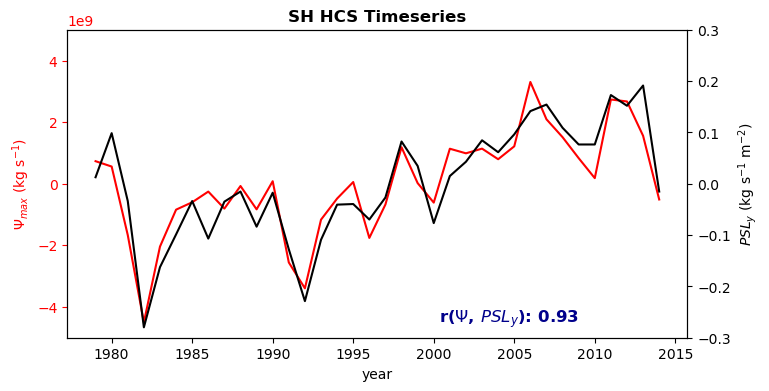

In [32]:
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(111)

# Anomaly of SH HCS from streamfunction
s_sh_ann_clim = s_sh_ann.mean('year')
s_sh_ann_anom = s_sh_ann - s_sh_ann_clim
t = s_sh_ann_anom.year

s_sh_ann_anom.plot(ax=ax1, color='r')
ax1.set_ylim([-5e9, 5e9])
ax1.set_ylabel(r'$\Psi_{max}$ (kg s$^{-1}$)', color='r')  
ax1.tick_params(axis='y', colors='r') 
ax1.set_title('SH HCS Timeseries', fontweight='bold') 

ax2 = ax1.twinx()
PSLy_sh_ann_clim = PSLy_sh_ann.mean('year')
PSLy_sh_ann_anom = PSLy_sh_ann - PSLy_sh_ann_clim
PSLy_sh_ann_anom.plot(ax=ax2, color='k')

ax2.set_ylim([-0.3, 0.3])
ax2.set_ylabel(r'$PSL_y$ (kg s$^{-1}$ m$^{-2}$)', color='k') 
ax2.tick_params(axis='y', colors='k')  
ax2.set_title('') 

# Correlation between two metrics
r_sh = xr.corr(s_sh_ann_anom, PSLy_sh_ann_anom).data
plt.text(0.60, 0.05, f'r($\Psi$, $PSL_y$): {r_sh:.2f}', transform=ax1.transAxes,
         fontsize=12, fontweight='bold', color='darkblue')
plt.show()

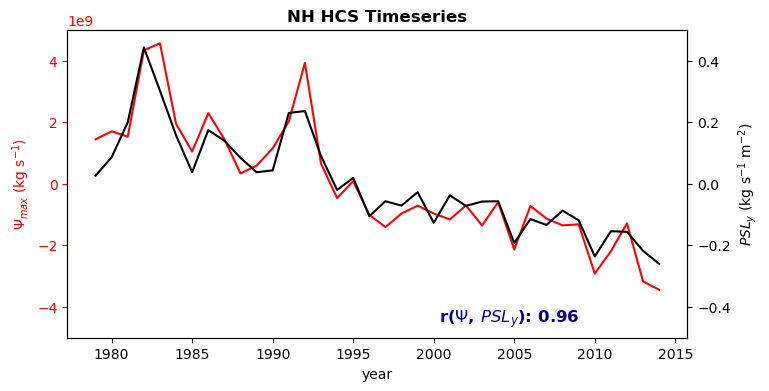

In [33]:
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(111)

# Anomaly of NH HCS from streamfunction
s_nh_ann_clim = s_nh_ann.mean('year')
s_nh_ann_anom = s_nh_ann - s_nh_ann_clim
t = s_nh_ann_anom.year

s_nh_ann_anom.plot(ax=ax1, color='r')
ax1.set_ylim([-5e9, 5e9])
ax1.set_ylabel(r'$\Psi_{max}$ (kg s$^{-1}$)', color='r')  
ax1.tick_params(axis='y', colors='r')  
ax1.set_title('NH HCS Timeseries', fontweight='bold')

# Twin axis for PSLy anomaly
ax2 = ax1.twinx()
PSLy_nh_ann_clim = PSLy_nh_ann.mean('year')
PSLy_nh_ann_anom = PSLy_nh_ann - PSLy_nh_ann_clim
PSLy_nh_ann_anom.plot(ax=ax2, color='k')

ax2.set_ylim([-0.5, 0.5])
ax2.set_ylabel(r'$PSL_y$ (kg s$^{-1}$ m$^{-2}$)', color='k') 
ax2.tick_params(axis='y', colors='k');ax2.set_title('')  

# Correlation between streamfunction-based HCS and SLP-based proxy
r_nh = xr.corr(s_nh_ann_anom, PSLy_nh_ann_anom).data
plt.text(0.60, 0.05, f'r($\Psi$, $PSL_y$): {r_nh:.2f}', transform=ax1.transAxes,
         fontsize=12, fontweight='bold', color='darkblue')
plt.show()